# Week 4

In [478]:
import sys
import scipy
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import datetime as dt
import cvxpy as cp

from pandas.plotting import register_matplotlib_converters
import seaborn as sns
sns.set()
register_matplotlib_converters()
%config InlineBackend.figure_format = 'retina'

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import KFold, GridSearchCV
from scipy.optimize import minimize
from pandas_datareader import data 

In [479]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [480]:
import ml_asset_kit as mla
sys.path.append("../")
import edhec_risk_kit as erk

In [481]:
# using seaborn style (type plt.style.available to see available styles)
plt.style.use("seaborn-dark")

In [282]:


#########################################################################################################
def regime_return(asset_pd, column_number, regime_col):
    """Computes returns of a list of regime columns identified by number"""
    asset_name = asset_pd.columns[column_number]
    regime = asset_pd[regime_col].values[:-1]
    asset_return = np.diff(asset_pd[asset_name],axis=0) / asset_pd[asset_name].values[:-1,:]
    ret_g, ret_c = asset_return[regime==1,:], asset_return[regime==-1,:] 
    return asset_return, ret_g, ret_c
#########################################################################################################




'''
def regime_hist(asset_pd, column_number, regime_col):
    asset_return, ret_g, ret_c = regime_return(asset_pd, column_number, regime_col)
    plt.hist(ret_g, bins=20, color='green', label='Growth Regime',alpha=0.3)
    plt.hist(ret_c, bins=15, color='red', label='Contraction Regime',alpha=0.3)
    plt.xlabel('Monthly Return')
    plt.ylabel('Frequency')
    plt.legend(loc='upper left')
    plt.title('Regime Histogram of Asset: ' + asset_name)
    return ret_g, ret_c
'''


'''
def Q_Q_plot(rets, linetype="r"):
    plt.figure(figsize=(9,6))
    #res = scipy.stats.probplot(ret[column_name], plot=plt) 
    res = sm.qqplot(rets.values, line=linetype)
    plt.title('Q-Q Plot: ' + column_name)
    plt.ylabel('returns')
    plt.grid()
    plt.show()
'''



'''
def regime_plot_cdf(ret_g, ret_c, column_name):
    xg, yg = ecdf(ret_g[column_name])
    xc, yc = ecdf(ret_c[column_name])
    fig, ax = plt.subplots(1,1,figsize=(9,6))
    ax.plot(xg, yg, color='green',label='Normal regime')
    ax.plot(xc, yc, color='red',label='Crash regime')
    ax.set_xlabel('monthly return')
    ax.set_ylabel('cumulative probability')
    ax.set_title("Cumulative Density of Asset: {}".format(column_name))
    ax.grid()
    ax.legend()
    plt.show()
    return ax
'''
    



'''
def plot_regime_color(dataset, regime_num=0, TR_num=1, lambda_value=16, log_TR = True):
    returns = dataset.iloc[:,regime_num]
    TR = dataset.iloc[:,TR_num]
    betas = trend_filtering(returns.values,lambda_value)
    regimelist = regime_switch(betas)
    curr_reg = np.sign(betas[0]-1e-5)
    y_max = np.max(TR) + 500
    
    if log_TR:
        fig, ax = plt.subplots()
        for i in range(len(regimelist)-1):
            if curr_reg == 1:
                ax.axhspan(0, y_max+500, xmin=regimelist[i]/regimelist[-1], xmax=regimelist[i+1]/regimelist[-1], 
                       facecolor='green', alpha=0.3)
            else:
                ax.axhspan(0, y_max+500, xmin=regimelist[i]/regimelist[-1], xmax=regimelist[i+1]/regimelist[-1], 
                       facecolor='red', alpha=0.5)
            curr_reg = -1 * curr_reg
        
        fig.set_size_inches(9,6)   
        plt.plot(TR, label='Total Return')
        plt.ylabel('SP500 Log-scale')
        plt.xlabel('Year')
        plt.yscale('log')
        plt.xlim([dataset.index[0], dataset.index[-1]])
        plt.ylim([80, 3000])
        plt.yticks([100, 500, 1000, 2000, 3000],[100, 500, 1000, 2000, 3000])
        plt.title('Regime Plot of SP 500', fontsize=24)
        plt.show()
'''
        
def geo_return(X, input_type='Return'):
    """Computes geometric return for each asset"""
    if input_type == 'Return':
        X_geo = 1+X
        y = np.cumprod(X_geo,axis=0)
        return (y[-1,:]) ** (1/X.shape[0]) - 1
    else:
        return (X[-1,:] / X[0,:]) ** (1/(X.shape[0]-1)) - 1

def portfolio_opt(mu, Q, r_bar):
    w = cp.Variable(mu.size)
    ret = mu.T*w 
    risk = cp.quad_form(w, Q)
    prob = cp.Problem(cp.Minimize(risk), 
                   [cp.sum(w) == 1, w >= 0, ret >= r_bar])
    prob.solve()
    return np.round_(w.value,decimals=3)

def efficient_frontier_traditional(r_annual, Q_all, r_bar):

    n_asset = r_annual.size
    weight_vec = np.zeros((len(r_bar),n_asset))
    risk_port = np.zeros(len(r_bar))
    ret_port = np.zeros(len(r_bar))

    for i, r_curr in enumerate(r_bar):
        w_opt = cp.Variable(r_annual.size)
        ret_opt = r_annual.T*w_opt 
        risk_opt = cp.quad_form(w_opt, Q_all)
        prob = cp.Problem(cp.Minimize(risk_opt), 
                       [cp.sum(w_opt) == 1, w_opt >= 0, ret_opt >= r_curr])
        prob.solve()

        weight_vec[i,:] = w_opt.value
        ret_port[i] = ret_opt.value
        risk_port[i] = np.sqrt(risk_opt.value)

    plt.figure(figsize=(12,9))    
    plt.plot(risk_port*100, ret_port*100, 'xb-')
    plt.xlabel("Risk (%)")
    plt.ylabel("Nominal Return (%)")
    plt.title("Efficient Frontier: Single-Period", fontsize=24);
    
def efficient_frontier_scenario(r_all_1, r_bar):
    Q_1 = np.cov(r_all_1.T)
    mu_1 = np.mean(r_all_1, axis=0)
    
    efficient_frontier_traditional(r_annual, Q_all, r_bar)
    plt.title("Efficient Frontier: Single-Period, Scenario-Equivalent Version", fontsize=24);
    
def efficient_frontier_comparison(r_annual, Q_all, r_bar, n_scenarios=10000):
    n_asset = r_annual.size
    weight_vec = np.zeros((len(r_bar),n_asset))
    risk_port = np.zeros(len(r_bar))
    ret_port = np.zeros(len(r_bar))

    for i, r_curr in enumerate(r_bar):
        w_opt = cp.Variable(r_annual.size)
        ret_opt = r_annual.T*w_opt 
        risk_opt = cp.quad_form(w_opt, Q_all)
        prob = cp.Problem(cp.Minimize(risk_opt), 
                       [cp.sum(w_opt) == 1, w_opt >= 0, ret_opt >= r_curr])
        prob.solve()

        weight_vec[i,:] = w_opt.value
        ret_port[i] = ret_opt.value
        risk_port[i] = np.sqrt(risk_opt.value)
    
    plt.subplot(121)
    plt.plot(risk_port*100, ret_port*100, 'xb-')
    plt.xlabel("Risk (%)")
    plt.ylabel("Nominal Return (%)")
    plt.title("Traditional", fontsize=16);
    
    r_all_1 = np.random.multivariate_normal(r_annual.reshape(n_asset), Q_all, n_scenarios)

    Q_1 = np.cov(r_all_1.T)
    mu_1 = np.mean(r_all_1, axis=0)
    weight_vec1 = np.zeros((len(r_bar),n_asset))
    risk_port1 = np.zeros(len(r_bar))
    ret_port1 = np.zeros(len(r_bar))

    for i, r_curr in enumerate(r_bar):
        w_opt = cp.Variable(r_annual.size)
        ret_opt = mu_1.T*w_opt
        risk_opt = cp.quad_form(w_opt, Q_1)
        prob = cp.Problem(cp.Minimize(risk_opt), 
                       [cp.sum(w_opt) == 1, w_opt >= 0, ret_opt >= r_curr])
        prob.solve()

        weight_vec1[i,:] = w_opt.value
        ret_port1[i] = ret_opt.value
        risk_port1[i] = np.sqrt(risk_opt.value)  
        
    plt.subplot(122)
    plt.plot(risk_port1*100, ret_port1*100, 'xb-')
    plt.xlabel("Risk (%)")
    plt.title("Scenario-Equivalent", fontsize=16);
    

    
    
'''
def efficient_frontier_twoRegime(ret, ret_g, ret_c, r_bar, n_scenarios = 10000):
    Q_all = np.cov(ret.T) * 12
    r_annual = (1+geo_return(ret)) ** 12 - 1
    r_annual = r_annual.reshape(-1,1)
    r_g = (1+geo_return(ret_g)) ** 12 - 1
    r_c = (1+geo_return(ret_c)) ** 12 - 1
    n_g = int(n_scenarios*ret_g.shape[0] / ret.shape[0])
    Q_g = np.cov(ret_g.T) * 12
    Q_c = np.cov(ret_c.T) * 12
    n_asset = r_annual.size

    s_1 = np.random.multivariate_normal(r_g, Q_g, n_g)
    s_2 = np.random.multivariate_normal(r_c, Q_c, n_scenarios-n_g)
    r_all_2 = np.vstack((s_1,s_2))

    Q_2 = np.cov(r_all_2.T)
    mu_2 = np.mean(r_all_2, axis=0)

    weight_vec2 = np.zeros((len(r_bar),n_asset))
    risk_port2 = np.zeros(len(r_bar))
    ret_port2 = np.zeros(len(r_bar))

    for i, r_curr in enumerate(r_bar):
        w_opt = cp.Variable(r_annual.size)
        ret_opt = mu_2.T*w_opt
        risk_opt = cp.quad_form(w_opt, Q_2)
        prob = cp.Problem(cp.Minimize(risk_opt), 
                       [cp.sum(w_opt) == 1, w_opt >= 0, ret_opt >= r_curr])
        prob.solve()

        weight_vec2[i,:] = w_opt.value
        ret_port2[i] = ret_opt.value
        risk_port2[i] = np.sqrt(risk_opt.value)

    efficient_frontier_traditional(r_annual, Q_all, r_bar)
    plt.plot(risk_port2*100, ret_port2*100, 'xr-',label='Two-Regime')
    plt.legend(loc='best', ncol=2, shadow=True, fancybox=True,fontsize=16)
    plt.title("Efficient Frontier: Single-Period, Traditional vs Two-Regime Version")
    plt.show()
    return r_all_2
'''

# Endowment Simulation: still in progress
def regime_asset(n,mu1,mu2,Q1,Q2,p1,p2):
    s_1 = np.random.multivariate_normal(mu1, Q1, n).T
    s_2 = np.random.multivariate_normal(mu2, Q2, n).T
    regime = np.ones(n)
    for i in range(n-1):
        if regime[i] == 1:
            if np.random.rand() > p1:
                regime[i+1] = 0
        else:
            if np.random.rand() > p2:
                regime[i+1] = 0
    return (regime*s_1 + (1-regime)*s_2).T

def transition_matrix(regime):
    """Computes the transition matrix given the regime vector
    """
    n1,n2,n3,n4 = 0,0,0,0
    for i in range(len(regime)-1):
        if regime[i] == 1:
            if regime[i+1] == 1:
                n1 += 1
            else:
                n2 += 1
        else:
            if regime[i+1] == 1:
                n3 += 1
            else:
                n4 += 1
    return n1/(n1+n2), n2/(n1+n2), n3/(n3+n4), n4/(n3+n4)

def asset_simulation(assets_info, asset_num, regime_name, random_seed=777, n_scenarios=10000, n_years=50):
    """Simulates regime-based monthly returns.
    assets_info is a pandas Dataframe containing asset total return indices; please refer to the dataset for format.
    asset_num is the number of assets we would like to use. By default, this should be the first few columns in dataset.
    regime_name is the column name of regime in the dataset.
    
    Returns a (n_year*12) * n_asset * n_scenario tensor for all asset information.
    """
    ret_all, ret_g, ret_c = regime_return(assets_info, np.arange(asset_num), 'Regime-5')
    regime = assets_info[regime_name].values[:-1] # lose 1 value from computing returns
    p1, _, p2, _ = transition_matrix(regime)
    mu1 = 1+geo_return(ret_g)
    mu2 = 1+geo_return(ret_c)
    Q1 = np.cov(ret_g.T)
    Q2 = np.cov(ret_c.T)
    r_all = np.zeros((n_years*12, asset_num, n_scenarios))
    
    np.random.seed(random_seed)
    for i in range(n_scenarios):
        r_all[:,:,i] = regime_asset(n_years*12,mu1,mu2,Q1,Q2,p1,p2)
    return r_all

def fund_simulation(holdings, asset_return, hold_type='fixed',spending_rate=0.03):
    """Simulates monthly data of a fund for a certain number of years.
    asset_return should be total return, i.e. 1 plus the percentage return.
    if hold_type is "fixed" (by default), holdings is fixed mix
    if hold_type is a number, this is rebalance frequency (in months) 
    if hold_type is "dynamic", dynamic portfolio optimization will be conducted (to be implemented...)
    
    The simulation returns a full path of wealth at the end of each year, so it is a n_scenarios*n_years matrix.
    """
    n_months, n_assets, n_scenarios = asset_return.shape
    wealth_path = np.zeros((n_scenarios, int(n_months/12)))
    
    if hold_type == 'fixed':
        for i in range(n_scenarios):
            holdings_each = holdings
            for j in range(n_months):
                holdings_each = holdings_each * asset_return[j,:,i]
                if j%12==0:
                    holdings_each = holdings_each * (1-spending_rate)
                    wealth_path[i,int(j/12)] = np.sum(holdings_each)
        return wealth_path
        
    elif type(hold_type)==int:
        for i in range(n_scenarios):
            holdings_each = holdings
            for j in range(n_months):
                holdings_each = holdings_each * asset_return[j,:,i]
                if j%hold_type == 0: # Rebalance
                    asset_temp = np.sum(holdings_each)
                    holdings_each = asset_temp * holdings
                if j%12==0:
                    holdings_each = holdings_each * (1-spending_rate)
                    wealth_path[i,int(j/12)] = np.sum(holdings_each)
        return wealth_path
    
    else: # "Dynamic" -- to be implemented
        return 0

# Regime-based Simulations and Multi-Period Portfolio Models

We will introduce the concept of **economic and market regimes**, demonstrate the significance of regime identification, evaluate the performance of regime identification methods.

## Introduction to Economic Regimes

A **regime** is a period of time in which the characteristics of market performance and related economic activity are reasonably stable. 

For better analysis of the market, we would like to categorize historical periods into a small number of regimes and evaluate each regime separately.

Let us plot the historical performance of the **US stock market index** (S&P 500) with regimes that we have determined (we will learn how to determine the regimes later):

In [466]:
asset_data = pd.read_csv("data/Assets_7.csv", index_col=0, header=0,parse_dates=[0])
asset_data.index = pd.to_datetime(asset_data.index,format="%Y-%m").to_period("M")
asset_data.head()

,US Equities,World Equities,US Treasuries,High Yield,Real Estate,Commodities,Corp Bonds,T-bill,TIPS,Regime-5,Regime-7,Regime-9
1985-01,3.69,443.231,100.0000,112.905,382.65,769.53,245.62,564.0916,0.30%,1,1,1
1985-02,3.99,455.868,101.9243,117.185,404.31,785.96,252.75,567.9944,-1.12%,1,1,1
1985-03,4.11,451.672,100.1330,118.672,410.96,774.00,246.33,571.6528,1.61%,1,1,1
1985-04,4.08,485.608,102.0311,119.185,408.20,802.77,251.11,575.8523,2.37%,1,1,1
1985-05,4.03,484.414,104.1377,121.356,408.57,774.58,256.72,579.6807,5.26%,1,1,1


In [467]:
# compute returns
rets = erk.compute_returns( asset_data.iloc[:,range(8)] )
rets = pd.concat([rets, asset_data.iloc[:,[8,9,10,11]]], axis=1).dropna() # dropping first row with NaN rets
rets.head()

,US Equities,World Equities,US Treasuries,High Yield,Real Estate,Commodities,Corp Bonds,T-bill,TIPS,Regime-5,Regime-7,Regime-9
1985-02,0.081301,0.028511,0.019243,0.037908,0.056605,0.021351,0.029029,0.006919,-1.12%,1,1,1
1985-03,0.030075,-0.009204,-0.017575,0.012689,0.016448,-0.015217,-0.025401,0.006441,1.61%,1,1,1
1985-04,-0.007299,0.075134,0.018956,0.004323,-0.006716,0.037171,0.019405,0.007346,2.37%,1,1,1
1985-05,-0.012255,-0.002459,0.020647,0.018215,0.000906,-0.035116,0.022341,0.006648,5.26%,1,1,1
1985-06,0.064516,0.040245,0.048570,0.042363,0.027241,0.004351,0.063610,0.006858,3.97%,1,1,1


In [468]:
# separate dataframe with respect to returns from a regular and crash regime given a regime vector
regime_name = "Regime-5"
rets_g = rets[rets[regime_name]==1]
rets_c = rets[rets[regime_name]==-1]

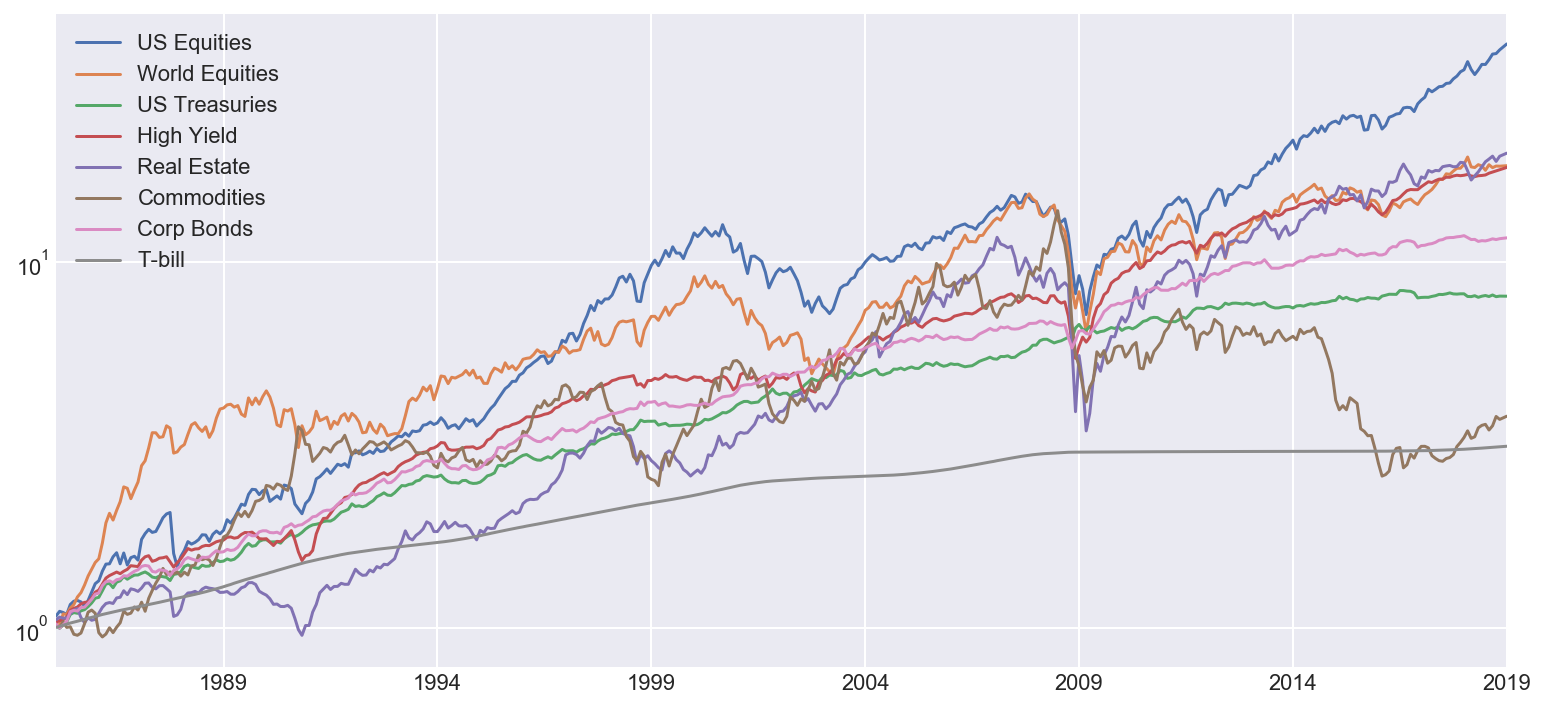

In [469]:
# plot asset wealths
( 1 + rets.iloc[:,range(8)] ).cumprod().plot(grid=True, figsize=(13,6), logy=True)
plt.show()

In [470]:
erk.summary_stats(rets.iloc[:,range(8)], risk_free_rate=0.0, periods_per_year=12)

,Ann. return,Ann. vol,Sharpe ratio,Skewness,Kurtosis,Historic CVar,C-F Var,Max Drawdown
US Equities,0.114126,0.155216,0.735270,-0.848029,6.249882,0.105823,0.070790,-0.530930
World Equities,0.089324,0.172688,0.517258,-0.402266,4.263287,0.113194,0.077762,-0.581763
US Treasuries,0.063357,0.046847,1.352412,0.238472,4.245303,0.022563,0.015725,-0.052445
High Yield,0.088982,0.082462,1.079061,-0.823557,11.658134,0.054620,0.032802,-0.333846
Real Estate,0.091857,0.189075,0.485823,-0.310908,19.034763,0.121518,0.067865,-0.703818
Commodities,0.040027,0.202868,0.197304,-0.407513,4.983119,0.133001,0.095442,-0.811461
Corp Bonds,0.074893,0.054117,1.383913,-0.360710,6.263009,0.029775,0.020041,-0.156373
T-bill,0.034262,0.007555,4.535324,0.168063,1.810217,-0.000017,0.000716,0.000000


In [456]:
#asset_name = "High Yield"
#asset_name = "US Treasuries"
#asset_name = "T-bill"
asset_name = "US Equities"

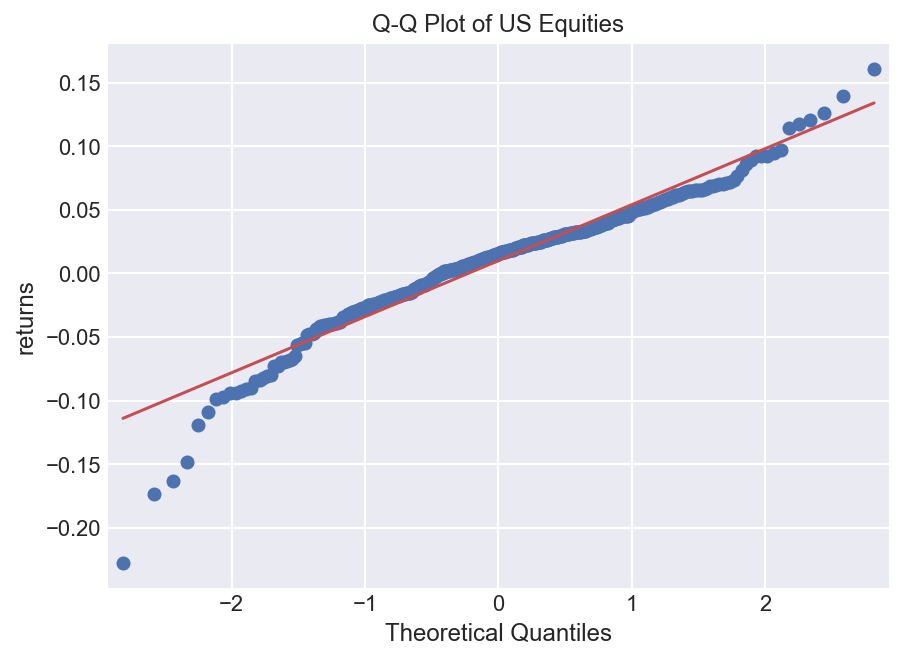

In [471]:
# Quantile-Quantile plot of assets
mla.qqplot(rets[asset_name], linetype="r")

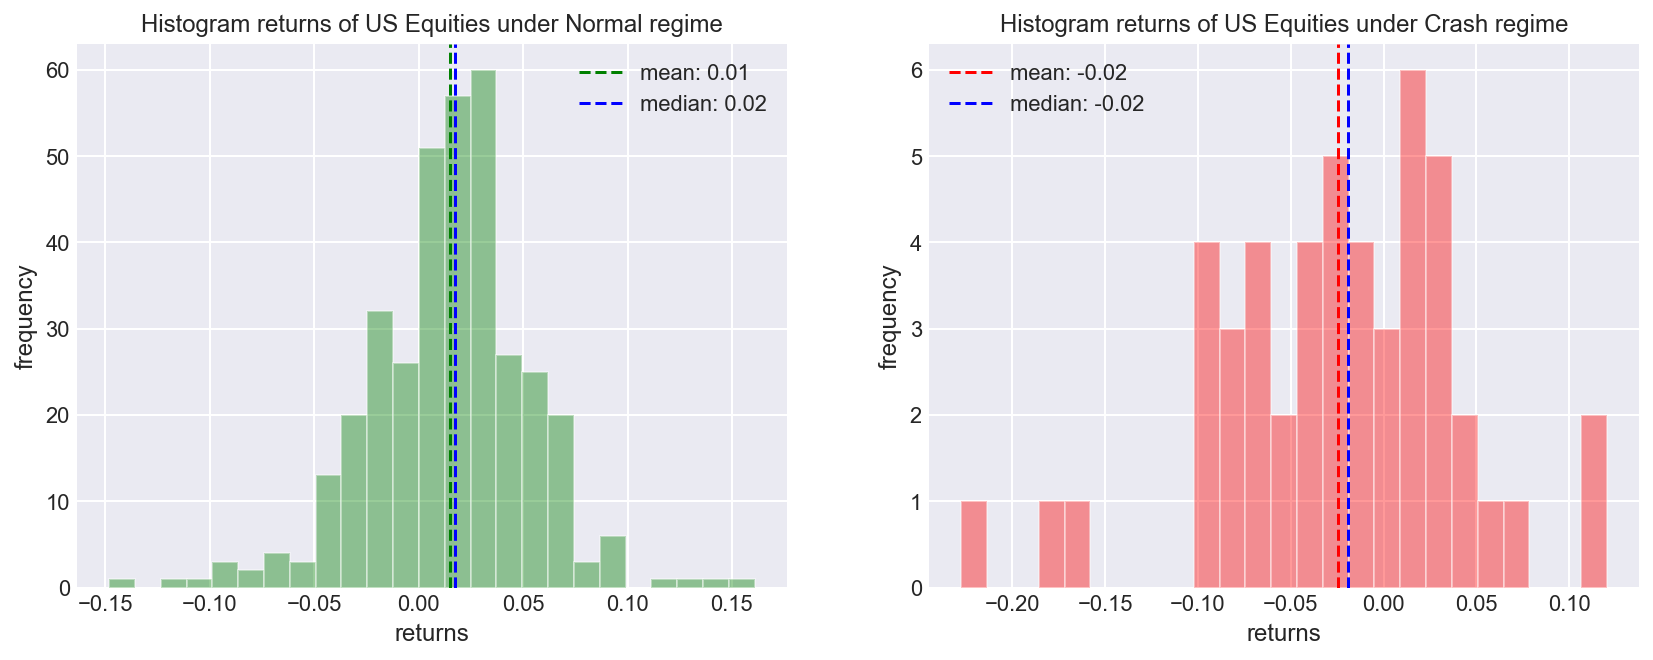

In [472]:
# Histogram returns of normal and crash regimes 
regime = rets["Regime-5"]
asset_rets = rets[asset_name]
ax = mla.regime_hist(asset_rets, regime)

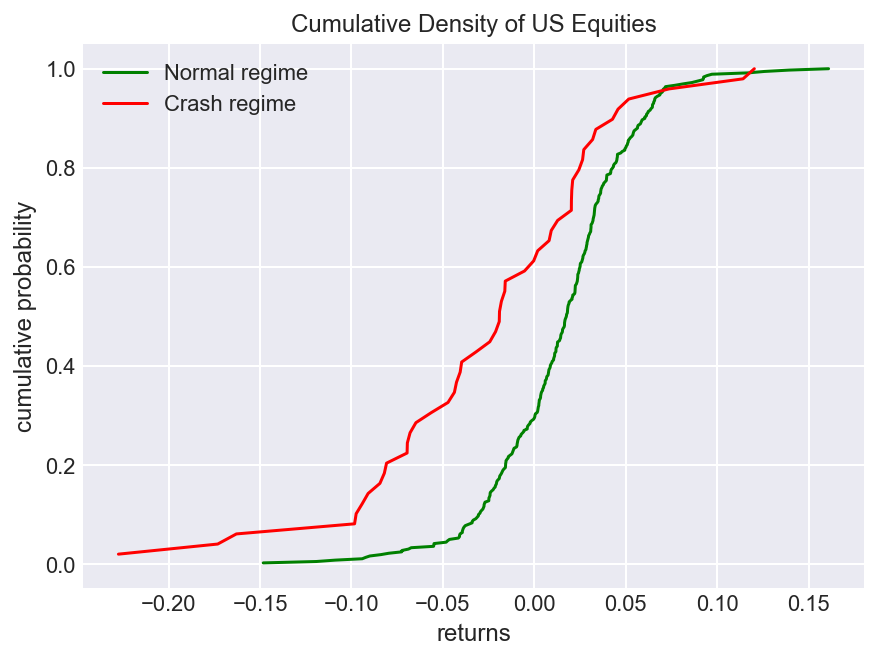

In [473]:
# Cumulative Distribution functions plot of the normal and crash regimes
ax = mla.regime_plot_cdf(rets_g[asset_name], rets_c[asset_name])

We can observe that the monthly return distribution of World Equities is very different under growth regime or contraction regime. 


## Identification of Regimes 

A **regime analysis** is significant in asset allocation and asset-liability management for long-term investors because of **the contagion** and related effects during crash periods: **the correlation between risky assets and volatility will greatly increase during the crash periods**, thus creating severe difficulty in risk management and protecting investor capital with traditional portfolio models.

Many existing methods are based on econometric models which assume a fixed structural model. However, financial return or macroeconomic data tends to be noisy and affected by myriad of factors. The state-of-the-art approach discussed in Mulvey and Liu (2016), **trend-filtering**, is non-parametric, data-driven and model-free. The algorithm was first introduced by Kim et al. (2009) and generalised in Tibshirani (2014).

In this part, we will implement the algorithm to obtain regimes of U.S. equity. First, we need the relevant packages and data.

In [474]:
# Import S&P500
sp500 = pd.read_csv("data/SP500.csv", index_col=0, header=0, parse_dates=[0])
sp500.columns = ["rets","value"]
sp500["rets"] = sp500["rets"] / 100
sp500.index = pd.to_datetime(sp500.index, format="%Y-%m").to_period("M")
sp500.index = sp500.index.rename("date")
sp500.head()

,rets,value
date,,
1985-01,0.005585,84.7932
1985-02,0.074747,91.1312
1985-03,0.055791,96.2155
1985-04,-0.011260,95.1321
1985-05,0.053201,100.1932


In the **trend-filtering algorithm**, we manage to find some **fitted time series** that serves as the signal of the trend. This new time series can be obtained by solving the following optimization problem:
$$
\hat{\beta} = \text{argmin}_{\beta \in \mathbb{R}^n} ||x-\beta||_2^2 + \lambda||D\beta||_1 .
$$
where
$$
D =
    \begin{pmatrix}
       1 & -1 & 0 & \dots & 0 & 0  \\
       0  & 1 &-1 & \dots & 0 & 0 \\
       \vdots \\
       0  & 0 & 0 & \dots & -1 & 0\\
       0  & 0 & 0 & \dots & 1 & -1
    \end{pmatrix}
\in \mathbb{R}^{(n-1)\times n}.
$$

In [475]:
lambda_value = 0.11

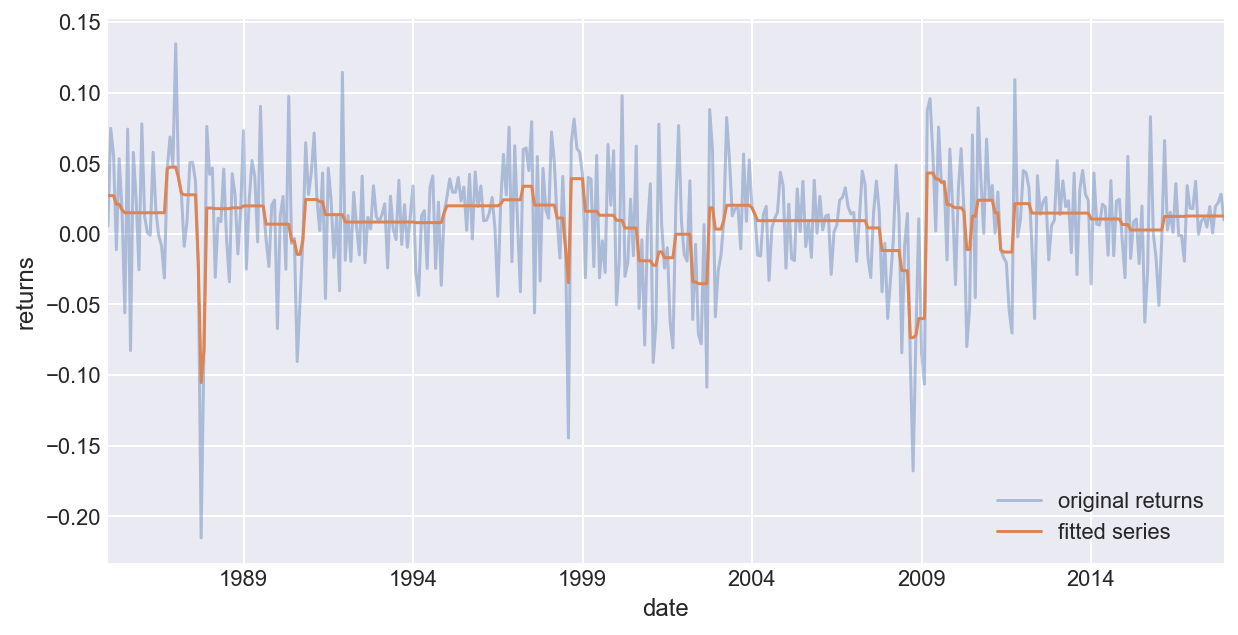

In [476]:
ax = mla.trend_filtering_plot(sp500["rets"], lambda_value=lambda_value, figx=10, figy=5)

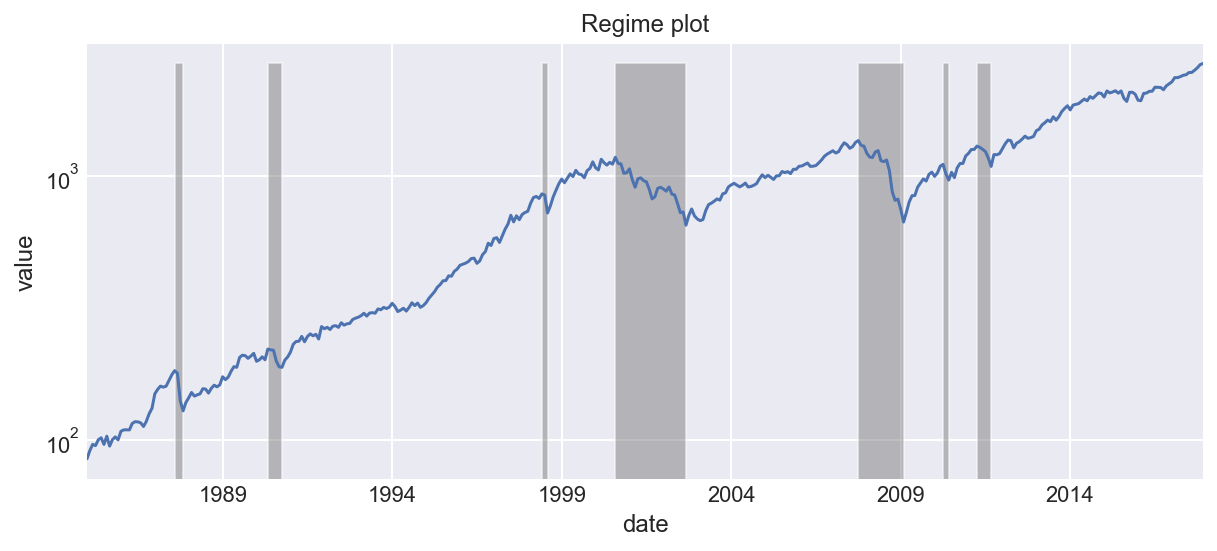

In [482]:
ax = mla.plot_regime_color(sp500["value"], lambda_value=lambda_value, figx=10, figy=4)

## A Regime-based Single Period Model 
Here we will deal with the simplest model: we have stocks, bonds and cash.

#### Regime Identification with the Trend-Filtering Algorithm 

We have done trend-filtering algorithm in the previous section. Now let's just take the regime from the dataset (column "Regime-5").

#### Parameter Estimation and Simulation



In [483]:
# Set Parameters
n_scenarios = 10000
m_freq = 12
#r_bar = np.arange(0.035,0.115,0.005)    # Range of expected returns

In [484]:
rets = rets.iloc[:,range(8)].dropna()
rets_g = rets_g.iloc[:,range(8)].dropna()
rets_c = rets_c.iloc[:,range(8)].dropna()

In [485]:
# covariance matrices times 12 as data are monthly)
Q_all = rets.cov().values * m_freq
Q_g = rets_g.cov().values * m_freq
Q_c = rets_c.cov().values * m_freq

In [486]:
#r_annual = (1 + geo_return(rets.values)) ** m_freq - 1
#r_annual = r_annual.reshape(-1,1)
#r_annual
ann_rets = erk.annualize_rets(rets, periods_per_year=12)
ann_rets

US Equities       0.114126
World Equities    0.089324
US Treasuries     0.063357
High Yield        0.088982
Real Estate       0.091857
Commodities       0.040027
Corp Bonds        0.074893
T-bill            0.034262
dtype: float64

In [487]:
rets_range = np.linspace(ann_rets.min(),ann_rets.max(),20)    # Range of expected returns

In [488]:
#r_1 = ( 1 + geo_return(rets.values) )   ** m_freq - 1
#r_g = ( 1 + geo_return(rets_g.values) ) ** m_freq - 1
#r_c = ( 1 + geo_return(rets_c.values) ) ** m_freq - 1
ann_rets_g = erk.annualize_rets(rets_g, periods_per_year=12)
ann_rets_c = erk.annualize_rets(rets_c, periods_per_year=12)

In [490]:
#n_g = int( n_scen * rets_g.shape[0] / rets.shape[0] )
#n_c = int( n_scen * rets_c.shape[0] / rets.shape[0] )

In [491]:
#efficient_frontier_traditional(ann_rets.values, Q_all, rets_range)

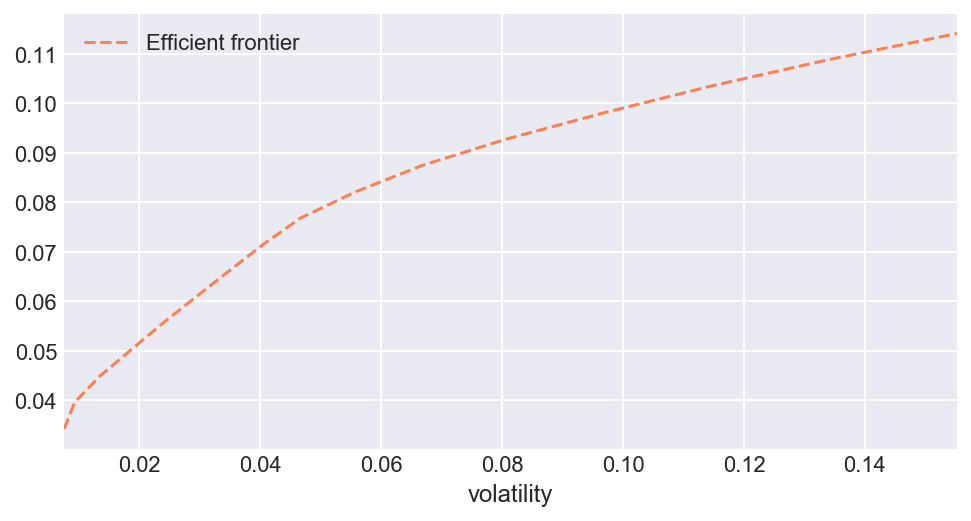

In [492]:
# which equivalent to 
df = erk.efficient_frontier(16, rets, rets.cov(), periods_per_year=12, iplot=True)

In [493]:
# Scenario Equivalent version
#r_all_1 = np.random.multivariate_normal(r_1, Q_all, n_scen)
#r_all_1

In [494]:
# Compare with scenario equivalent
#efficient_frontier_comparison(r_annual, Q_all, r_bar)

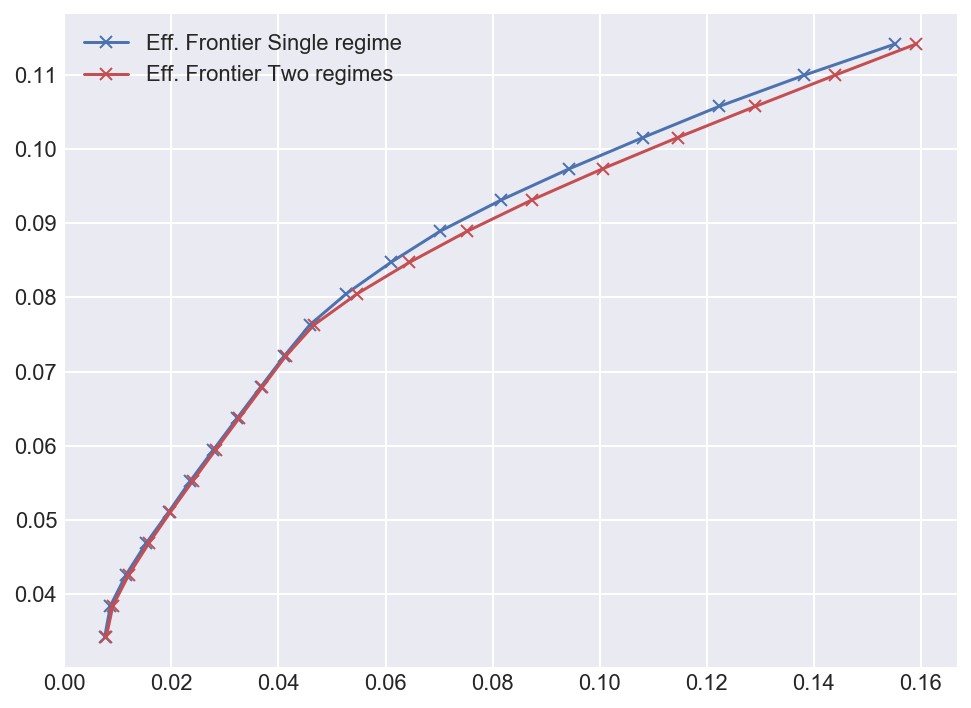

In [495]:
ax = mla.efficient_frontier_two_regimes(rets, rets_g, rets_c, periods_per_year=12, n_ports=20, n_scenarios=10000, figx=8, figy=6)

In [515]:
def geo_return_2(X, input_type='Return'):
    """Computes geometric return for each asset"""
    if input_type == 'Return':
        X_geo = 1+X
        y = np.cumprod(X_geo,axis=0)
        return (y[-1,:]) ** (1/X.shape[0]) - 1
    else:
        return (X[-1,:] / X[0,:]) ** (1/(X.shape[0]-1)) - 1


def regime_asset_2(n,mu1,mu2,Q1,Q2,p1,p2):
    s_1 = np.random.multivariate_normal(mu1, Q1, n).T
    s_2 = np.random.multivariate_normal(mu2, Q2, n).T
    regime = np.ones(n)
    for i in range(n-1):
        if regime[i] == 1:
            if np.random.rand() > p1:
                regime[i+1] = 0
        else:
            if np.random.rand() < p2:
                regime[i+1] = 1
    return (regime*s_1 + (1-regime)*s_2).T

def transition_matrix_2(regime):
    '''
    Computes the transition matrix given the regime vector. Here
    - p11 is the probability of staying in regime 1 given that current regime is 1
    - p12 is the probability of moving to regime 2 given that current regime is 1
    - p21 is the probability of moving to regime 1 given that current regime is 2
    - p22 is the probability of staying in regime 2 given that current regime is 2
    Note that in the regime vector, regime 1 is 1 (supposed to be normal) 
    and regime 2 is -1 (supposed to be crash). 
    '''
    n1,n2,n3,n4 = 0,0,0,0
    for i in range(len(regime)-1):
        if regime[i] == 1:
            # current regime is 1
            if regime[i+1] == 1:
                n1 += 1
            else:
                n2 += 1
        else:
            # current regime is 0
            if regime[i+1] == 1:
                n3 += 1
            else:
                n4 += 1
    p11 = n1 / (n1+n2)
    p12 = n2 / (n1+n2)
    p21 = n3 / (n3+n4)
    p22 = n4 / (n3+n4)
    return p11, p12, p21, p22

'''
def asset_simulation(assets_info, asset_num, regime_name, random_seed=777, n_scenarios=10000, n_years=50):
    Simulates regime-based monthly returns.
    assets_info is a pandas Dataframe containing asset total return indices; please refer to the dataset for format.
    asset_num is the number of assets we would like to use. By default, this should be the first few columns in dataset.
    regime_name is the column name of regime in the dataset.
    Returns a (n_year*12) * n_asset * n_scenario tensor for all asset information.
    
    ret_all, ret_g, ret_c = regime_return(assets_info, np.arange(asset_num), 'Regime-5')
    regime = assets_info[regime_name].values[:-1] # lose 1 value from computing returns
    p1, _, p2, _ = transition_matrix(regime)
    mu1 = 1+geo_return(ret_g)
    mu2 = 1+geo_return(ret_c)
    Q1 = np.cov(ret_g.T)
    Q2 = np.cov(ret_c.T)
    r_all = np.zeros((n_years*12, asset_num, n_scenarios))
    
    np.random.seed(random_seed)
    for i in range(n_scenarios):
        r_all[:,:,i] = regime_asset(n_years*12,mu1,mu2,Q1,Q2,p1,p2)
    return r_all
'''

def regime_based_simulated_rets(data, assets_name, regime_name, periods_per_years=12, n_years=50, n_scenarios=1000, rand_seed=777):
    '''
    Simulates regime-based returns givne in input pd.Dataframe data and a regime vector 
    identified by regime_name (which is a column of data).
    The variable assets_name denotes the columns' name of data corresponding to the assets we want to use.
    The simulated results are stored into a (n_year*periods_per_years)*len(assets_name)*n_scenario tensor 
    '''
    # compute returns
    rets_all = erk.compute_returns( data[assets_name] ).dropna()
    # returns of regular and crash regime according to the regime vector 
    rets_g = rets_all[ (data[regime_name]==1)[1:]  ]
    rets_c = rets_all[ (data[regime_name]==-1)[1:] ]
    # compute transition probabilities 
    p1, _, p2, _ = transition_matrix_2( data[regime_name] )
    # return per months
    #mu1 = ( (1+rets_g).prod() )**(1/rets_g.shape[0]) - 1
    #mu2 = ( (1+rets_c).prod() )**(1/rets_c.shape[0]) - 1
    
    mu1 = 1 + geo_return_2(rets_g.values)
    mu2 = 1 + geo_return_2(rets_c.values)

    # covariances
    Q1 = rets_g.cov()
    Q2 = rets_c.cov()
    
    if rand_seed is not None:
        np.random.seed(rand_seed)

    r_all = np.zeros((n_years*periods_per_years, len(assets_name), n_scenarios))
    for i in range(n_scenarios):
        r_all[:,:,i] = regime_asset_2(n_years*periods_per_years,mu1,mu2,Q1,Q2,p1,p2)
    
    return r_all





def fund_simulation_2(holdings, asset_return, hold_type='fixed',spending_rate=0.03):
    """Simulates monthly data of a fund for a certain number of years.
    asset_return should be total return, i.e. 1 plus the percentage return.
    if hold_type is "fixed" (by default), holdings is fixed mix
    if hold_type is a number, this is rebalance frequency (in months) 
    if hold_type is "dynamic", dynamic portfolio optimization will be conducted (to be implemented...)
    
    The simulation returns a full path of wealth at the end of each year, so it is a n_scenarios*n_years matrix.
    """
    n_months, n_assets, n_scenarios = asset_return.shape
    wealth_path = np.zeros((n_scenarios, int(n_months/12)))
    
    if hold_type == 'fixed':
        for i in range(n_scenarios):
            holdings_each = holdings
            for j in range(n_months):
                holdings_each = holdings_each * asset_return[j,:,i]
                if j%12==0:
                    holdings_each = holdings_each * (1-spending_rate)
                    wealth_path[i,int(j/12)] = np.sum(holdings_each)
        return wealth_path
        
    elif type(hold_type)==int:
        for i in range(n_scenarios):
            holdings_each = holdings
            for j in range(n_months):
                holdings_each = holdings_each * asset_return[j,:,i]
                if j%hold_type == 0: # Rebalance
                    asset_temp = np.sum(holdings_each)
                    holdings_each = asset_temp * holdings
                if j%12==0:
                    holdings_each = holdings_each * (1-spending_rate)
                    wealth_path[i,int(j/12)] = np.sum(holdings_each)
        return wealth_path
    
    else: # "Dynamic" -- to be implemented
        return 0

In [516]:
n_scenarios = 100
assets_name = asset_data.columns[:8]
r_all = regime_based_simulated_rets(asset_data, assets_name, regime_name="Regime-5", periods_per_years=12, 
                                    n_years=50, n_scenarios=n_scenarios) #, rand_seed=777)

In [517]:
r_all.shape

(600, 8, 100)

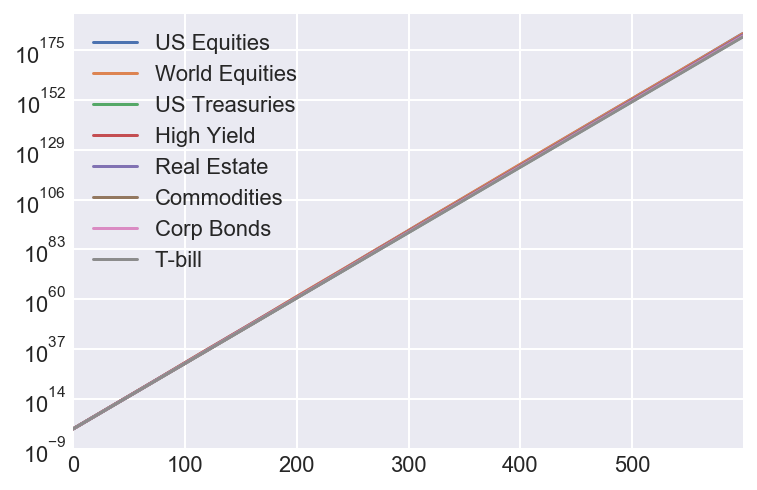

In [518]:
erk.compound_returns( pd.DataFrame(r_all[:,:,0], columns=assets_name) , start=1).plot(grid=True, logy=True)

In [519]:
#pd.DataFrame(r_all[:,:,0], columns=assets_name).head() #["World Equities"].mean()

In [520]:
start = 1
holdings = np.array([.3, 0.1, 0.1, .2, .1, 0.05, 0.1, .05])
ww = pd.DataFrame( [holdings]*r_all.shape[0], columns=assets_name)


portf_sim = pd.DataFrame()
for n in range(n_scenarios):
    sim_rets = pd.DataFrame(r_all[:,:,n], columns=assets_name)
    portfolio_rets = ww.multiply(sim_rets).sum(axis=1)
    portfolio_wealth = erk.compound_returns(portfolio_rets, start=start)
    portf_sim = pd.concat([portf_sim,portfolio_wealth], axis=1)

portf_sim.columns = range(r_all.shape[2])

years = np.arange(0,portf_sim.shape[0],12)
portf_sim = portf_sim.iloc[years,:]

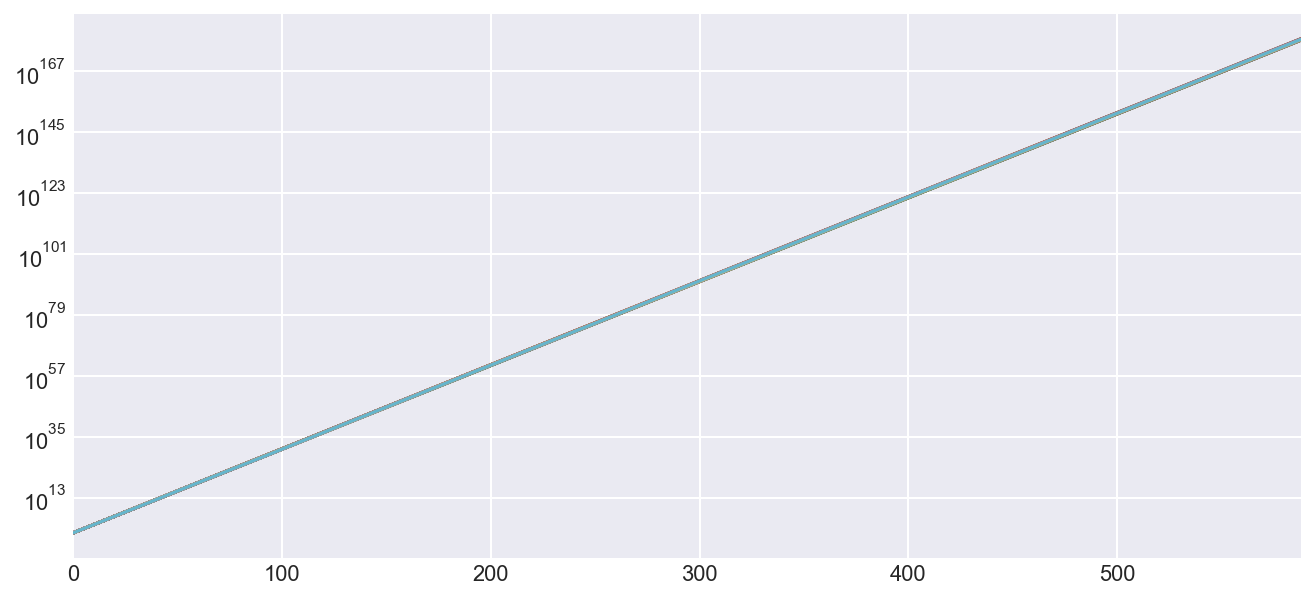

In [521]:
portf_sim.plot(grid=True, figsize=(11,5), logy=True, legend=False)

In [511]:
#ww = pd.DataFrame( [holdings]*r_all.shape[0], columns=r_first.columns)
#p  = ww.multiply(r_first).sum(axis=1)
#erk.compound_returns(p, start=1)  #.iloc[0,:] * holdings

In [512]:
#risky_allocation * (1 + risky_rets.iloc[step] ) + safe_allocation  * (1 + safe_rets.iloc[step]  )


In [349]:
#erk.annualize_rets( pd.DataFrame(r_all[:,:,0], columns=assets_name) , periods_per_year=12)

In [534]:
holdings = np.array([.3, 0, .2, .2, .1, 0, .15, .05])
result_temp = fund_simulation(holdings, r_all, spending_rate=0.1)

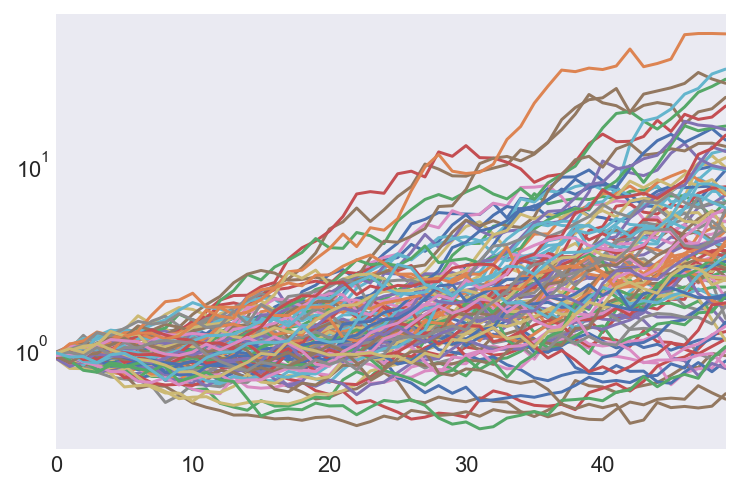

In [535]:
pd.DataFrame(result_temp.T).iloc[:,:100].plot(legend=False, logy=True)

In [514]:
# original 
#mu1 = 1 + geo_return_2(rets_g.values)
#mu2 = 1 + geo_return_2(rets_c.values)
# geo_return computes the return per month + 1. The same as: 
#(1+rets_g).cumprod().iloc[-1,:]**(1/rets_g.shape[0])
#(1+rets_g).prod()**(1/rets_g.shape[0])

# return per month
#r_total = (1+rets_g).prod()-1
#r_pm = (1+r_total)**(1/rets_g.shape[0])-1
#r_pm

In [516]:
# right one: return per month
mu1 = ( (1+rets_g).prod() )**(1/rets_g.shape[0]) - 1
mu2 = ( (1+rets_c).prod() )**(1/rets_c.shape[0]) - 1
# geo_return computes the return per month + 1. The same as: 
#(1+rets_g).cumprod().iloc[-1,:]**(1/rets_g.shape[0])
#(1+rets_g).prod()**(1/rets_g.shape[0])
